# 따릉이 대여량 예측

In [54]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv]
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
fc-cache: invalid option -- ']'
usage: fc-cache [-EfrsvVh] [-y SYSROOT] [--error-on-no-fonts] [--force|--really-force] [--sysroot=SYSROOT] [--system-only] [--verbose] [--version] [--help] [dirs]
Build font information caches in [dirs]
(all directories in font configuration by default).

  -E, --error-on-no-fonts  raise an error if no fonts in a directory
  -f, --force              scan directories with apparently valid caches
  -r, --really-force       erase all existing caches, then rescan
  -s, --system-only        scan system-wide directories only
  -y, --sysroot=SYSROOT    prepend SYSROOT to all paths for scanning
  -v, --verbose   

In [55]:
# 드라이브 사용 설정
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 살펴보기

In [56]:
# 데이터 로드
import pandas as pd

train = pd.read_csv('/content/drive/MyDrive/따릉이/train.csv')
test = pd.read_csv('/content/drive/MyDrive/따릉이/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/따릉이/sample_submission.csv')

## 데이터 전처리

In [57]:
train['year'] = train['date_time'].apply(lambda x : x.split('-')[0]) # 년
train['month'] = train['date_time'].apply(lambda x : x.split('-')[1]) # 월
train['day'] = train['date_time'].apply(lambda x : x.split('-')[2]) # 일

In [58]:
train['year'] = train['year'].apply(lambda x : int(x))
train['month'] = train['month'].apply(lambda x : int(x))
train['day'] = train['day'].apply(lambda x : int(x))

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.rcParams['font.size'] = 15
plt.style.use('ggplot')
plt.rc('font', family='NanumGothic')

In [60]:
train['hot_score'] = train['high_temp'] * train['humidity']
train['cold_score'] = train['wind_speed'] / train['low_temp']

In [61]:
train = train.drop(['day'], axis=1)
train = train.drop(['date_time'], axis=1)

In [62]:
train.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,hot_score,cold_score
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1575.000000,0.242063
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,1326.827000,0.255854
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,1146.846764,0.260861
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,888.628432,0.377526
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,768.903064,0.542298


In [63]:
# date_time 쪼개기 -> year, month, day
test['year'] = test['date_time'].apply(lambda x : x.split('-')[0])
test['month'] = test['date_time'].apply(lambda x : x.split('-')[1])
test['day'] = test['date_time'].apply(lambda x : x.split('-')[2])

# 요일 정보 추가
week_day = pd.to_datetime(test['date_time']).dt.day_name()
test['week_day'] = week_day

# 가공한 변수 타입 변경
test['year'] = test['year'].astype('int')
test['month'] = test['month'].astype('int')
test['day'] = test['day'].astype('int')

test.loc[test['week_day'] == 'Sunday', 'week_day'] = 0
test.loc[test['week_day'] == 'Monday', 'week_day'] = 1
test.loc[test['week_day'] == 'Tuesday', 'week_day'] = 2
test.loc[test['week_day'] == 'Wednesday', 'week_day'] = 3
test.loc[test['week_day'] == 'Thursday', 'week_day'] = 4
test.loc[test['week_day'] == 'Friday', 'week_day'] = 5
test.loc[test['week_day'] == 'Saturday', 'week_day'] = 6
test['week_day'] = test['week_day'].astype('int')

test.head()

,date_time,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,day,week_day
0,2021-04-01,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,1,4
1,2021-04-02,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,2,5
2,2021-04-03,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,3,6
3,2021-04-04,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,4,0
4,2021-04-05,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,5,1


In [64]:
# 피쳐 제거
test = test.drop(['week_day'],axis = 1)
test = test.drop(['day'],axis = 1)
test = test.drop(['date_time'],axis = 1)

# 더위 점수
test['hot_score'] = test['high_temp'] * test['humidity']

# 추위 점수
test['cold_score'] = test['wind_speed'] / test['low_temp']

test.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,year,month,hot_score,cold_score
0,108.833,3.000,0.000,2.900,28.333,11.800,20.667,18.333,2021,4,585.558111,0.245763
1,116.717,3.850,0.000,2.662,46.417,12.000,19.000,28.500,2021,4,881.923000,0.221833
2,82.669,4.000,0.565,2.165,77.258,8.875,16.368,52.847,2021,4,1264.558944,0.243944
3,44.123,3.466,0.466,3.747,63.288,6.250,17.368,37.671,2021,4,1099.185984,0.599520
4,147.791,1.500,0.000,1.560,48.176,7.188,18.684,4.459,2021,4,900.120384,0.217028


## EDA

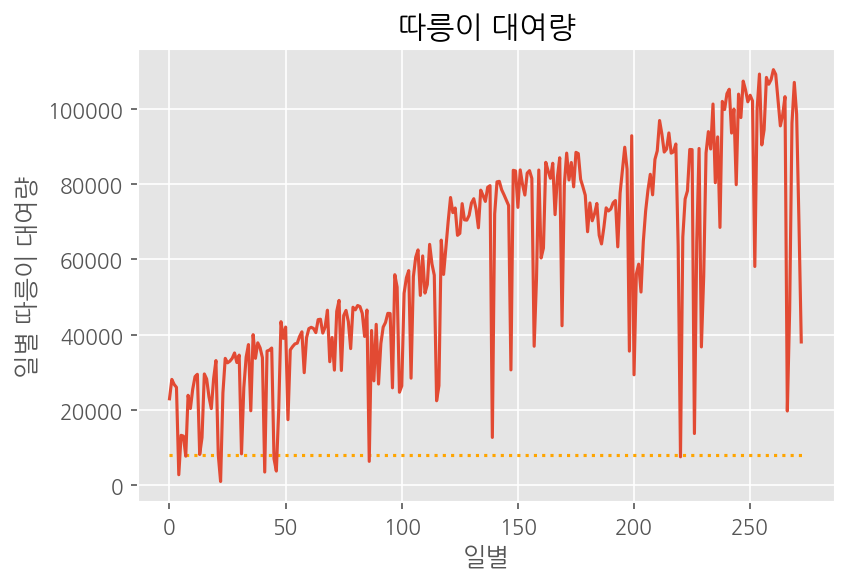

In [100]:
plt.figure(dpi=150)

x = train['number_of_rentals'].index
y = train['number_of_rentals'].values

plt.title('따릉이 대여량')
plt.xlabel('일별')
plt.ylabel('일별 따릉이 대여량')
plt.hlines(y=8000, xmin=0, xmax=len(x), color='Orange', linestyle='dotted')
plt.plot(x,y)
plt.show()

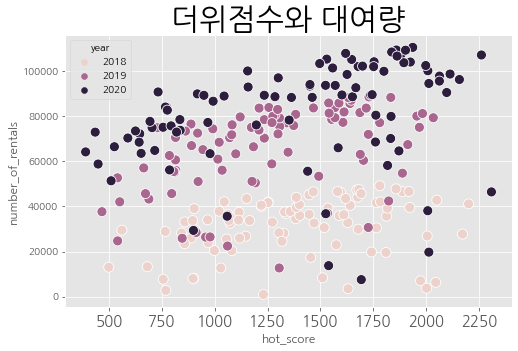

In [106]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=train['hot_score'], y=train['number_of_rentals'], hue=train['year'], s=100)
plt.xticks(fontsize=15)
plt.title('더위점수와 대여량', fontsize=30)
plt.show()

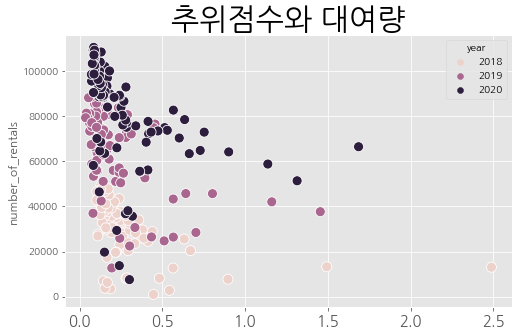

In [107]:
cold_score = train['wind_speed'] / train['low_temp']

plt.figure(figsize=(8,5))
sns.scatterplot(x=cold_score, y=train['number_of_rentals'], hue=train['year'], s=100)
plt.xticks(fontsize=15)
plt.title('추위점수와 대여량', fontsize=30)
plt.show()

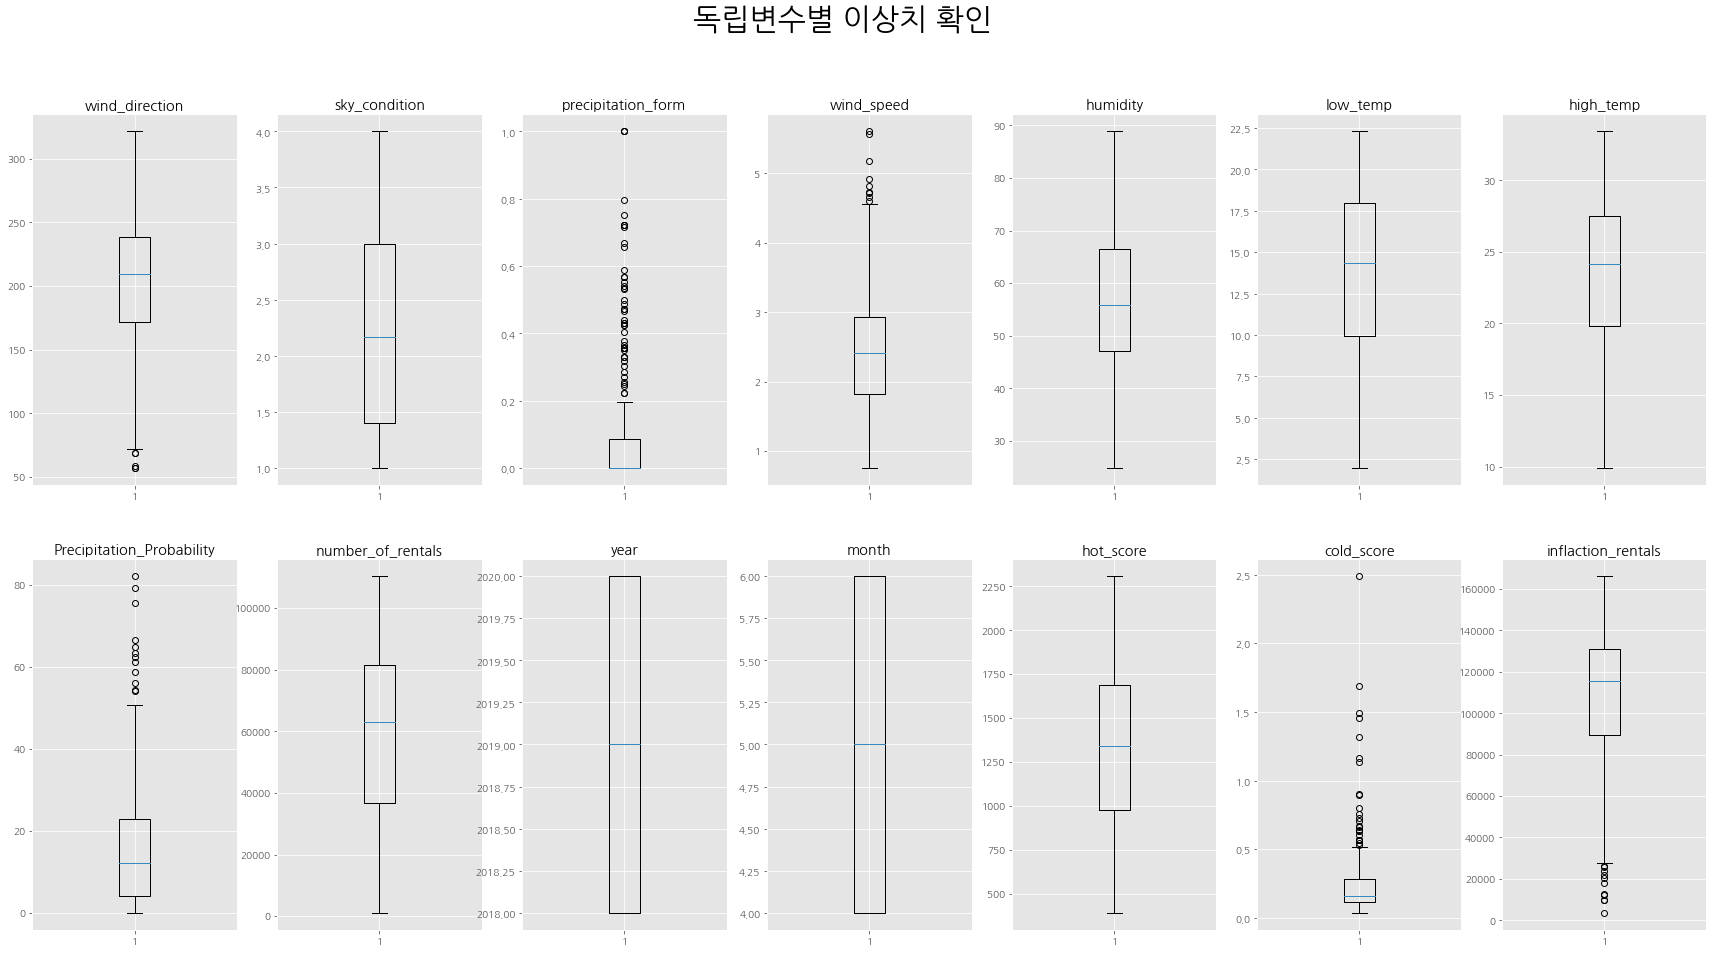

In [108]:
plt.style.use("ggplot")

feature =train.describe().columns # 수치형 변수만

plt.figure(figsize=(30,15))
plt.suptitle('독립변수별 이상치 확인', fontsize=30)

for i in range(len(feature)):
  plt.subplot(2,7,i+1)
  plt.title(feature[i])
  plt.boxplot(train[feature[i]])

plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


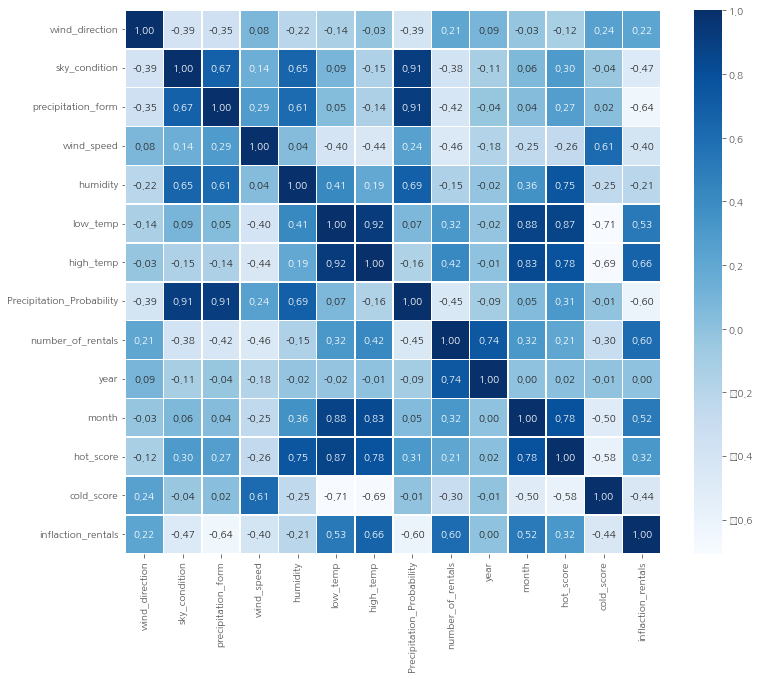

In [109]:
plt.figure(figsize=(12,10))
sns.heatmap(data=train.corr(method='pearson'), annot=True, fmt='.2f', linewidths=.5, cmap='Blues')

## Feature Engineering

In [115]:
x1 = sum(train[train['year'] == 2018]['number_of_rentals'])

x2 = sum(train[train['year'] == 2019]['number_of_rentals'])

x3 = sum(train[train['year'] == 2020]['number_of_rentals'])

In [116]:
y1 = train[train['year'] == 2018]['number_of_rentals'] * 2.5898531680403214
y2 = train[train['year'] == 2019]['number_of_rentals'] * 1.2358394161314505
y3 = train[train['year'] == 2020]['number_of_rentals']

pd.concat([y1,y2,y3], axis=0).to_frame()

,number_of_rentals
0,59551.083746
1,72875.878295
2,69452.092407
3,67424.237377
4,7337.054025
...,...
268,96150.000000
269,107001.000000
270,98568.000000
271,70053.000000


In [117]:
temp = train[['year', 'number_of_rentals']]
temp['inflation_rentals'] = pd.concat([y1,y2,y3], axis=0).to_frame()
temp[:183]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,year,number_of_rentals,inflation_rentals
0,2018,22994,59551.083746
1,2018,28139,72875.878295
2,2018,26817,69452.092407
3,2018,26034,67424.237377
4,2018,2833,7337.054025
...,...,...,...
178,2019,79234,97920.500298
179,2019,77056,95228.842049
180,2019,67346,83228.841319
181,2019,74994,92680.541173


In [123]:
X = train.drop(['number_of_rentals', 'inflaction_rentals'], axis=1)
y = train['inflaction_rentals']

In [124]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [125]:
model.fit(X,y)

LinearRegression()

In [126]:
predict = model.predict(test)

In [127]:
submission['number_of_rentals'] = predict
submission.head()

,date_time,number_of_rentals
0,2021-04-01,94888.021483
1,2021-04-02,88594.443216
2,2021-04-03,30066.246372
3,2021-04-04,42350.928948
4,2021-04-05,94083.518514


In [129]:
x1 = sum(train[train['year'] == 2018]['number_of_rentals'])

x2 = sum(train[train['year'] == 2019]['number_of_rentals'])

x3 = sum(train[train['year'] == 2020]['number_of_rentals'])

x4 = sum(submission['number_of_rentals']) ## 2021

In [130]:
print(x4/x1)
print(x4/x2)
print(x4/x3)

3.1380161868682137
1.4974146565709383
1.2116579525018687


In [131]:
def rental_rate_change(df):
    y1 = df[df['year'] == 2018]['number_of_rentals'] * 3.3859145348144577
    y2 = df[df['year'] == 2019]['number_of_rentals'] * 1.6157080615278123
    y3 = df[df['year'] == 2020]['number_of_rentals'] * 1.3073770268514862
    new = pd.concat([y1, y2, y3], axis=0).to_frame()
    df['inflaction_rentals'] = new['number_of_rentals']
    return True

In [132]:
rental_rate_change(train)

True

In [133]:
train.head()

,wind_direction,sky_condition,precipitation_form,wind_speed,humidity,low_temp,high_temp,Precipitation_Probability,number_of_rentals,year,month,hot_score,cold_score,inflaction_rentals
0,207.500,4.000,0.000,3.050,75.000,12.600,21.000,30.000,22994,2018,4,1575.000000,0.242063,77855.718814
1,208.317,2.950,0.000,3.278,69.833,12.812,19.000,19.500,28139,2018,4,1326.827000,0.255854,95276.249095
2,213.516,2.911,0.000,2.690,74.879,10.312,15.316,19.113,26817,2018,4,1146.846764,0.260861,90800.070080
3,143.836,3.692,0.425,3.138,71.849,8.312,12.368,43.493,26034,2018,4,888.628432,0.377526,88148.898999
4,95.905,4.000,0.723,3.186,73.784,5.875,10.421,63.378,2833,2018,4,768.903064,0.542298,9592.295877


In [134]:
X = train.drop(['number_of_rentals', 'inflaction_rentals'], axis=1 )
y = train['inflaction_rentals']

In [135]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()

## 하이퍼파라미터 튜닝

In [136]:
from sklearn.model_selection import GridSearchCV

In [137]:
param = {'min_samples_split': [30, 50, 70],
        'max_depth': [5, 6, 7],
        'n_estimators': [50, 150, 250]}

In [138]:
gs = GridSearchCV(estimator=model, param_grid=param, scoring = 'neg_mean_squared_error', cv = 3)

In [139]:
gs.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 6, 7],
                         'min_samples_split': [30, 50, 70],
                         'n_estimators': [50, 150, 250]},
             scoring='neg_mean_squared_error')

In [140]:
predict = gs.predict(test)

In [141]:
submission['number_of_rentals'] = predict
submission.head()

,date_time,number_of_rentals
0,2021-04-01,98327.367562
1,2021-04-02,92690.603221
2,2021-04-03,45584.025444
3,2021-04-04,51722.317149
4,2021-04-05,93900.519681


In [142]:
submission.to_csv('submission_gs.csv', index = False)

- 결과 : 0.1619206382

In [143]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 30, 'n_estimators': 150}

In [144]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071941,0.003444,0.006253,0.000352,5,30,50,"{'max_depth': 5, 'min_samples_split': 30, 'n_e...",-5.681580e+08,-4.264185e+08,-2.697963e+08,-4.214576e+08,1.218562e+08,4
1,0.204909,0.005729,0.012850,0.000072,5,30,150,"{'max_depth': 5, 'min_samples_split': 30, 'n_e...",-5.627292e+08,-4.143974e+08,-2.732151e+08,-4.167805e+08,1.182056e+08,1
2,0.342875,0.003850,0.020445,0.000722,5,30,250,"{'max_depth': 5, 'min_samples_split': 30, 'n_e...",-5.603182e+08,-4.191697e+08,-2.925309e+08,-4.240063e+08,1.093772e+08,5
3,0.063769,0.000552,0.005860,0.000230,5,50,50,"{'max_depth': 5, 'min_samples_split': 50, 'n_e...",-6.953854e+08,-4.320679e+08,-3.128177e+08,-4.800903e+08,1.598314e+08,15
4,0.195432,0.007043,0.012728,0.000170,5,50,150,"{'max_depth': 5, 'min_samples_split': 50, 'n_e...",-6.867017e+08,-4.562452e+08,-3.017181e+08,-4.815550e+08,1.581846e+08,16
5,0.322165,0.009513,0.022245,0.002454,5,50,250,"{'max_depth': 5, 'min_samples_split': 50, 'n_e...",-7.079906e+08,-4.255075e+08,-3.025908e+08,-4.786963e+08,1.697234e+08,14
6,0.062091,0.000235,0.005956,0.000294,5,70,50,"{'max_depth': 5, 'min_samples_split': 70, 'n_e...",-7.385415e+08,-4.704924e+08,-3.668300e+08,-5.252880e+08,1.566190e+08,21
7,0.185731,0.004548,0.013923,0.002063,5,70,150,"{'max_depth': 5, 'min_samples_split': 70, 'n_e...",-8.154461e+08,-4.316302e+08,-3.456652e+08,-5.309138e+08,2.042326e+08,25
8,0.306128,0.005114,0.019628,0.000183,5,70,250,"{'max_depth': 5, 'min_samples_split': 70, 'n_e...",-7.511637e+08,-4.467907e+08,-3.521781e+08,-5.167108e+08,1.702234e+08,20
9,0.068671,0.001099,0.005803,0.000038,6,30,50,"{'max_depth': 6, 'min_samples_split': 30, 'n_e...",-5.785514e+08,-4.065733e+08,-3.002076e+08,-4.284441e+08,1.146809e+08,9


In [145]:
from sklearn.model_selection import RandomizedSearchCV

In [146]:
param = {'min_samples_split': range(30, 70),
        'max_depth': [5, 6, 7],
        'n_estimators': range(50, 250)}

In [147]:
model = RandomForestRegressor()

In [148]:
rs = RandomizedSearchCV(estimator=model, param_distributions=param, n_iter = 30, random_state=0, scoring = 'neg_mean_squared_error', n_jobs = -1)

In [149]:
rs.fit(X,y)

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': [5, 6, 7],
                                        'min_samples_split': range(30, 70),
                                        'n_estimators': range(50, 250)},
                   random_state=0, scoring='neg_mean_squared_error')

In [150]:
rs.best_params_

{'max_depth': 7, 'min_samples_split': 34, 'n_estimators': 171}

In [151]:
predict = rs.predict(test)

In [152]:
submission['number_of_rentals'] = predict
submission.head()

,date_time,number_of_rentals
0,2021-04-01,98469.233784
1,2021-04-02,92225.901725
2,2021-04-03,46052.274466
3,2021-04-04,53945.348408
4,2021-04-05,93032.271941


In [153]:
submission.to_csv('submission_rs.csv', index = False)

- 결과 : 0.1629322531

In [154]:
model = RandomForestRegressor(n_estimators=500, n_jobs = -1, random_state=10, min_samples_split=30)

In [155]:
model.fit(X,y)

RandomForestRegressor(min_samples_split=30, n_estimators=500, n_jobs=-1,
                      random_state=10)

In [156]:
predict = model.predict(test)

In [157]:
submission['number_of_rentals'] = predict
submission.head()

,date_time,number_of_rentals
0,2021-04-01,98815.684912
1,2021-04-02,94515.257399
2,2021-04-03,46245.245228
3,2021-04-04,53600.295777
4,2021-04-05,92798.355401


In [158]:
submission.to_csv('submission_hp.csv', index = False)

- 결과 : 0.1611498794	